Trial 90 Complete [00h 00m 10s]
val_accuracy: 0.7870370149612427

Best val_accuracy So Far: 0.8240740895271301
Total elapsed time: 00h 06m 52s
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7214 - loss: 0.6114 - val_accuracy: 0.7500 - val_loss: 0.4749
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7608 - loss: 0.4590 - val_accuracy: 0.7500 - val_loss: 0.4780
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7603 - loss: 0.4765 - val_accuracy: 0.7685 - val_loss: 0.4787
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7779 - loss: 0.4468 - val_accuracy: 0.7685 - val_loss: 0.4810
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7994 - loss: 0.4431 - val_accuracy: 0.7407 - val_loss: 0.4976
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7915 - loss: 0.4118 - val_accuracy: 0.7685 - val_loss: 0.5011
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8077 - loss: 0.3710 - val_accuracy: 

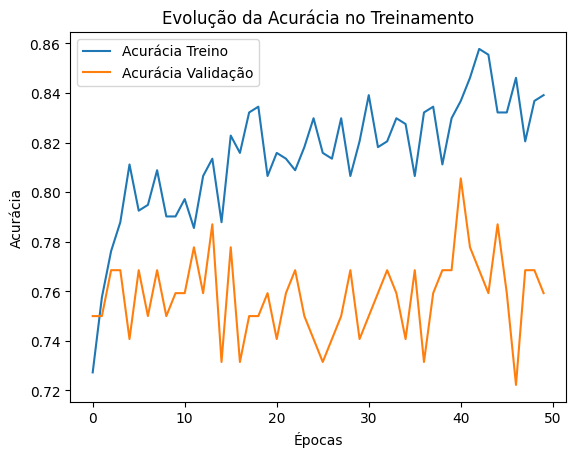

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Relatório de Classificação (Diabetes):
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       151
           1       0.62      0.54      0.58        80

    accuracy                           0.73       231
   macro avg       0.70      0.68      0.69       231
weighted avg       0.72      0.73      0.72       231



In [1]:
# Baixando Keras Tuner
!pip install keras-tuner -q

# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Carregar o dataset de Diabetes
diabetes = pd.read_csv('https://github.com/EdgarNoda/INTI6-2024/raw/refs/heads/main/datasets/Diabetes/diabetes.csv')

# Separar as features e a variável alvo
X = diabetes.drop(columns=['Outcome'])
y = diabetes['Outcome']

# Normalizar os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construção da Rede Neural (Modelo Inicial)
model_diabetes = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model_diabetes.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo inicial
history_diabetes = model_diabetes.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo inicial
loss, accuracy = model_diabetes.evaluate(X_test, y_test)
print(f"Acurácia (Diabetes - Modelo Inicial): {accuracy:.2f}")

# Função para construir o modelo com Keras Tuner
def build_model(hp):
    model = Sequential([
        Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
              input_dim=X_train.shape[1], activation='relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)),
        Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Criar um tuner e iniciar a busca por hiperparâmetros
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='diabetes_rna'
)

# Iniciar a busca
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Obter o melhor modelo e avaliá-lo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Obter o valor otimizado de 'epochs'
best_epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 50

# Treinar o melhor modelo
history = model.fit(X_train, y_train, epochs=best_epochs, validation_split=0.2)

# Avaliar o modelo otimizado
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia (Diabetes - Modelo Otimizado): {accuracy:.2f}")

# Visualizar a evolução do treinamento
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.title('Evolução da Acurácia no Treinamento')
    plt.show()

plot_history(history)

# Exibir métricas detalhadas no conjunto de teste
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nRelatório de Classificação (Diabetes):")
print(classification_report(y_test, y_pred))